# Import thư viện cần thiết

In [ ]:
pip install seaborn


[Loader] Loading MNIST...

[Loader] Loading 20News...

[Loader] Loading Ecommerce...

PHASE 1: EVALUATION (Dynamic k)
>>> Processing MNIST (N=60000, d=784) -> Calculated k=784
>>> Processing 20Newsgroups (N=11314, d=56126) -> Calculated k=8000
>>> Processing Ecommerce (N=540455, d=2200) -> Calculated k=2200

PHASE 2: FULL ABLATION (Density, Convergence, Scalability)
>>> ABLATION 1: Density vs Theory (Ecommerce)
>>> ABLATION 2: Convergence of k (MNIST)
>>> ABLATION 3: Scalability (20Newsgroups)


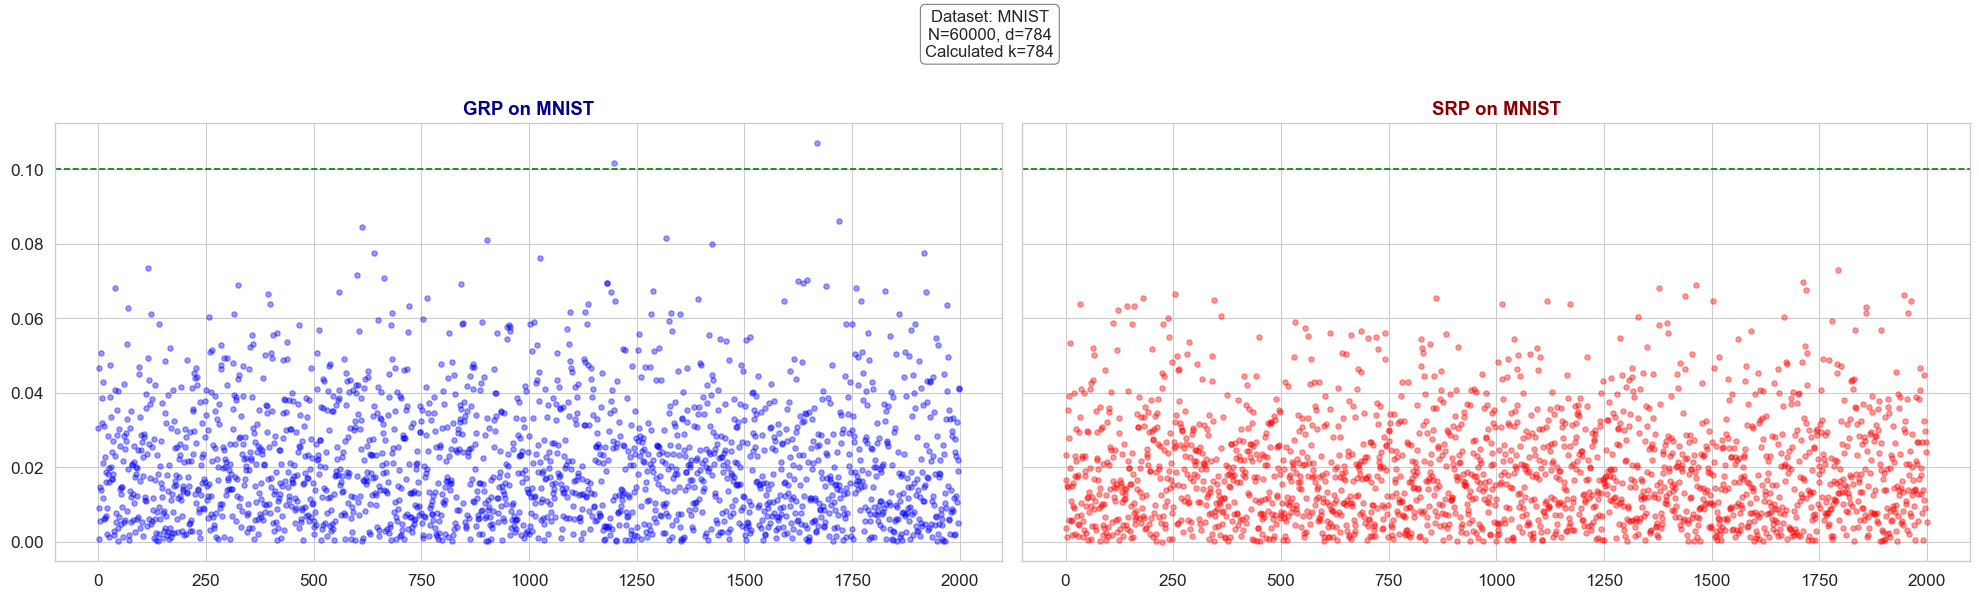

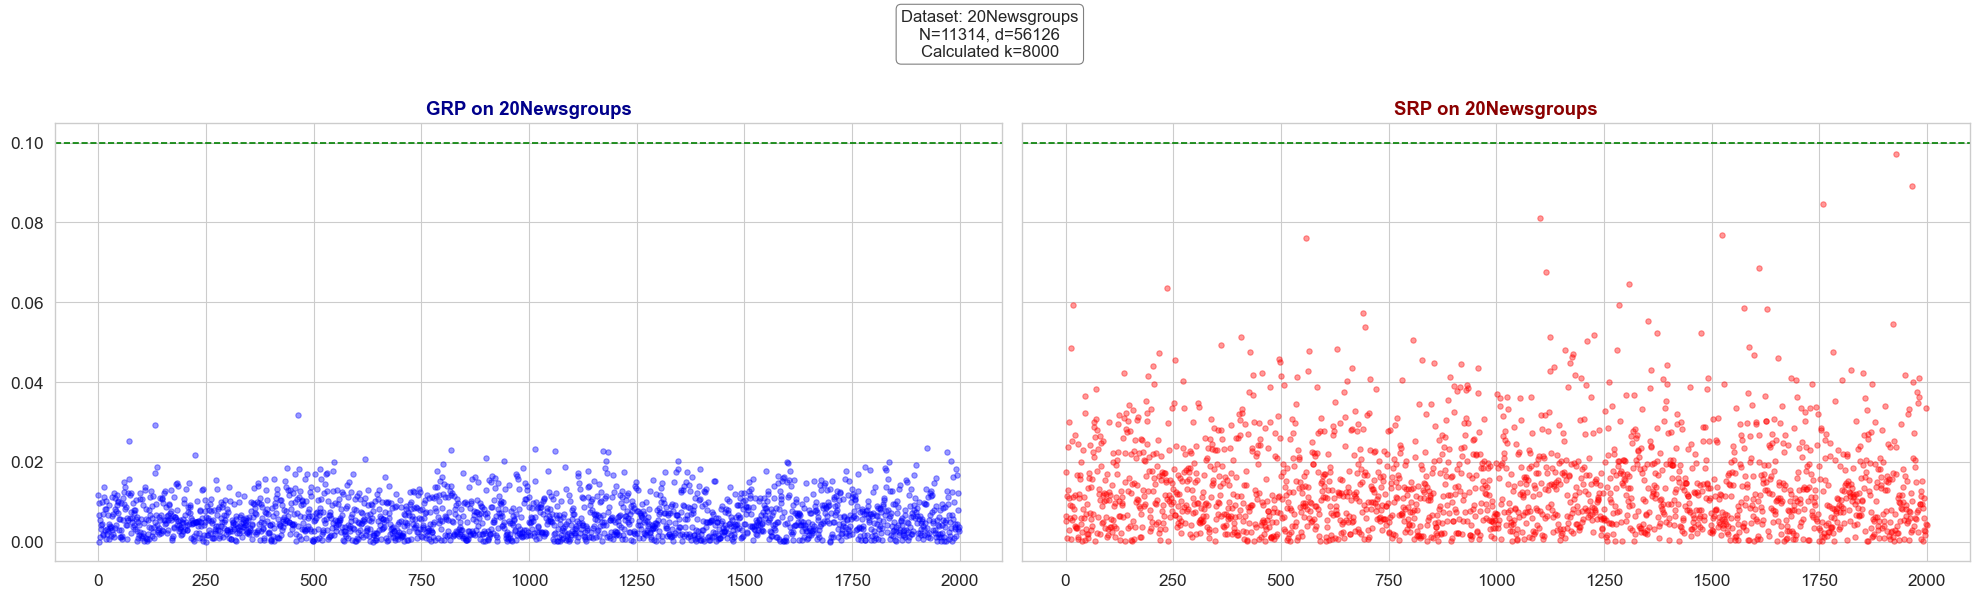

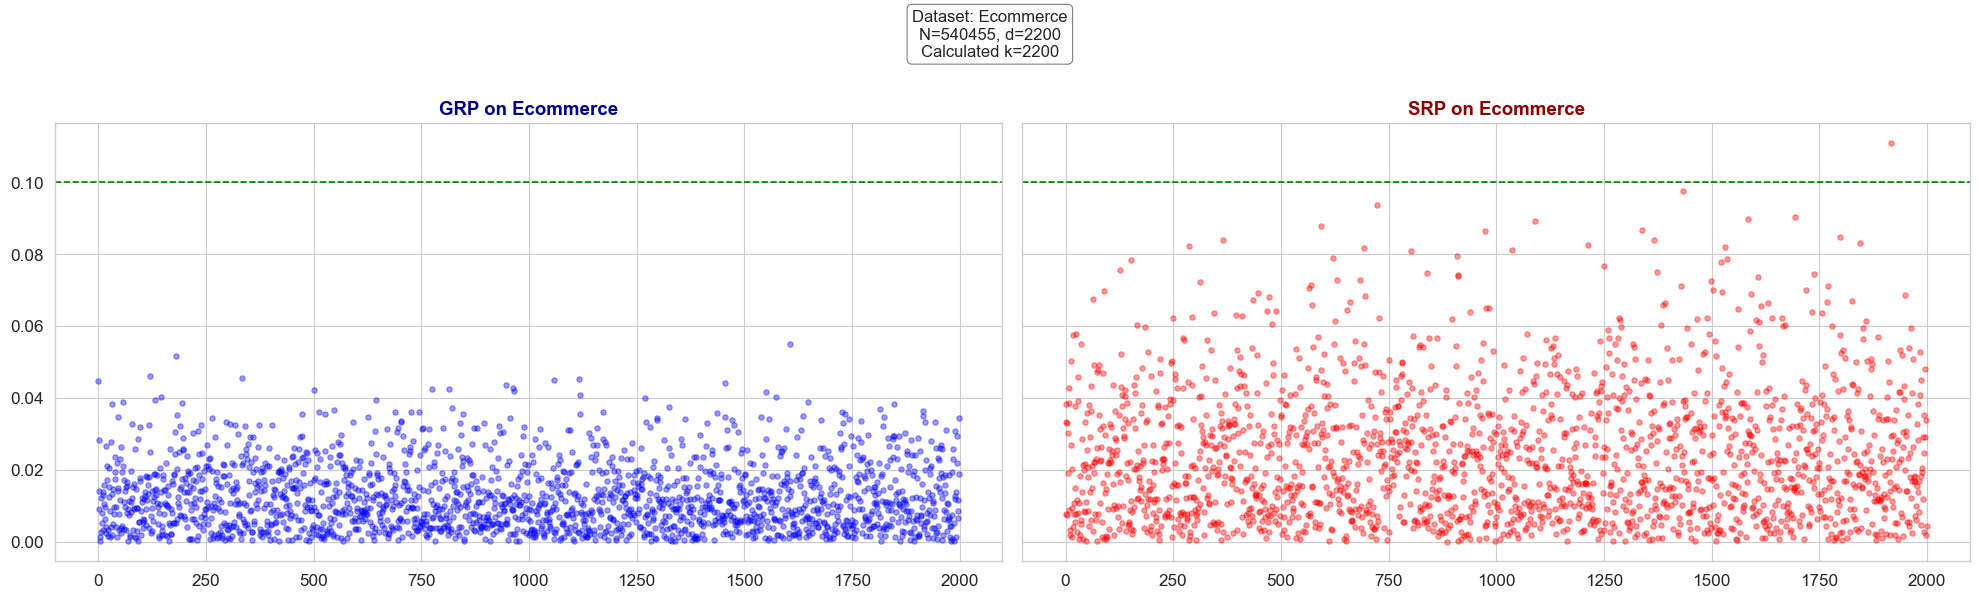

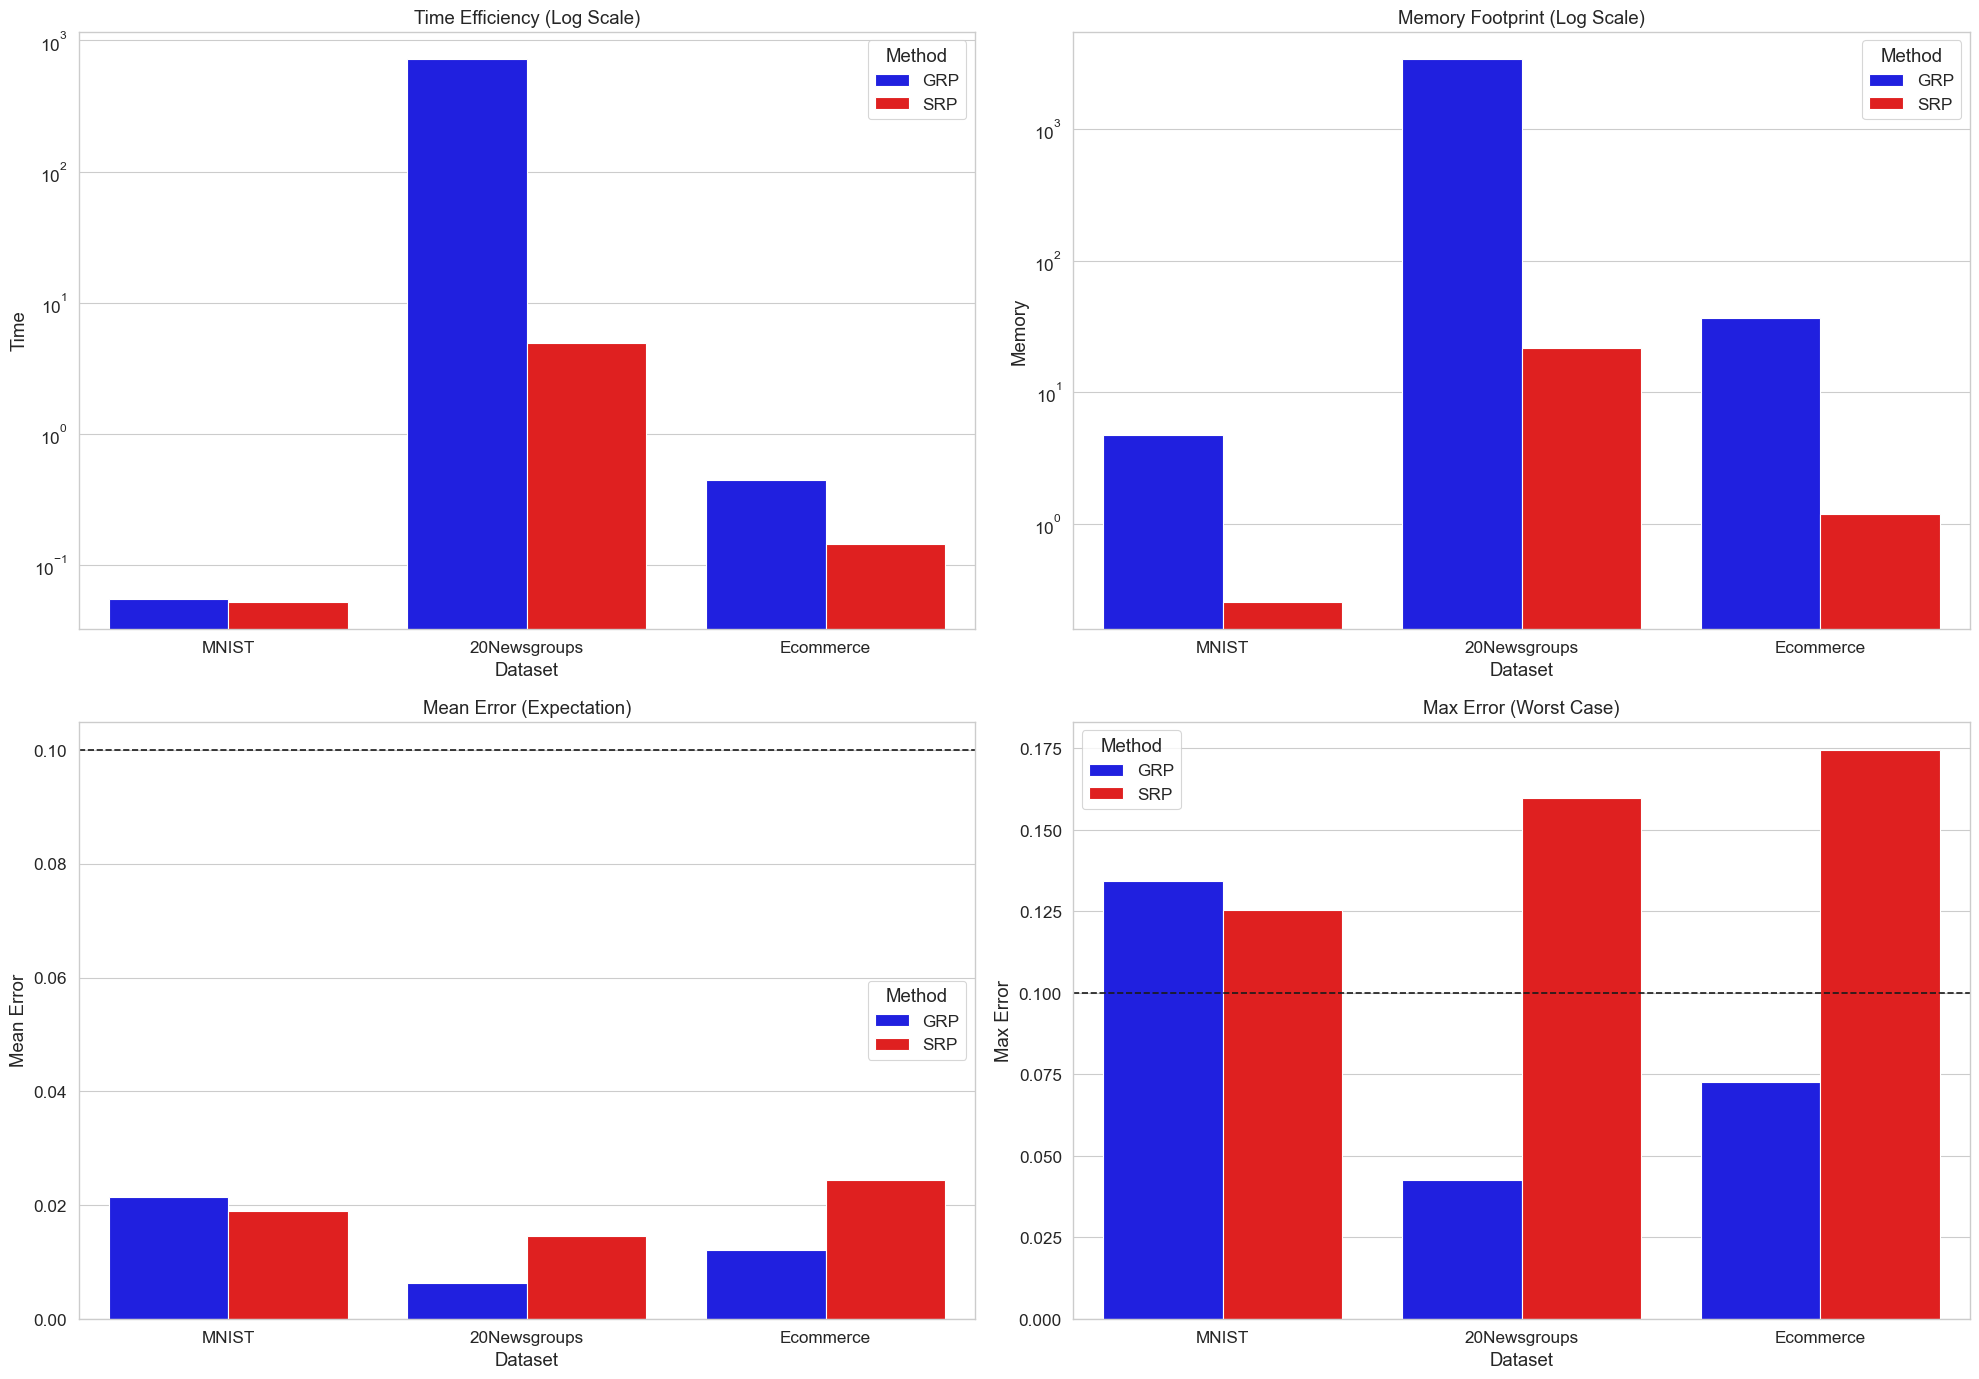

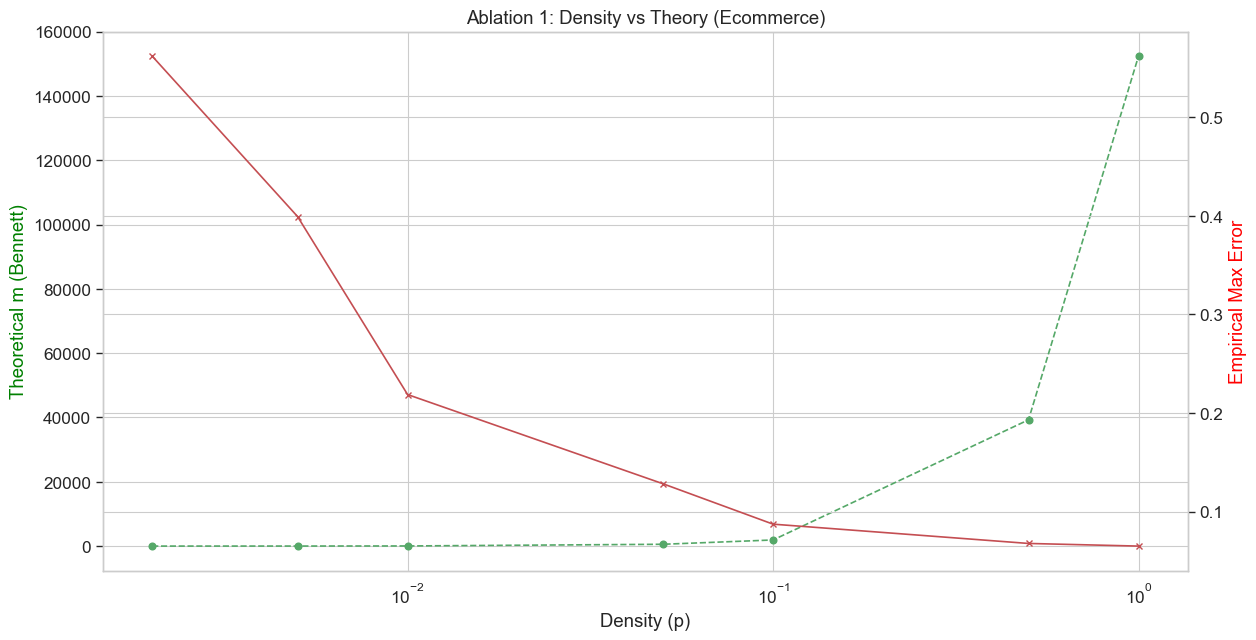

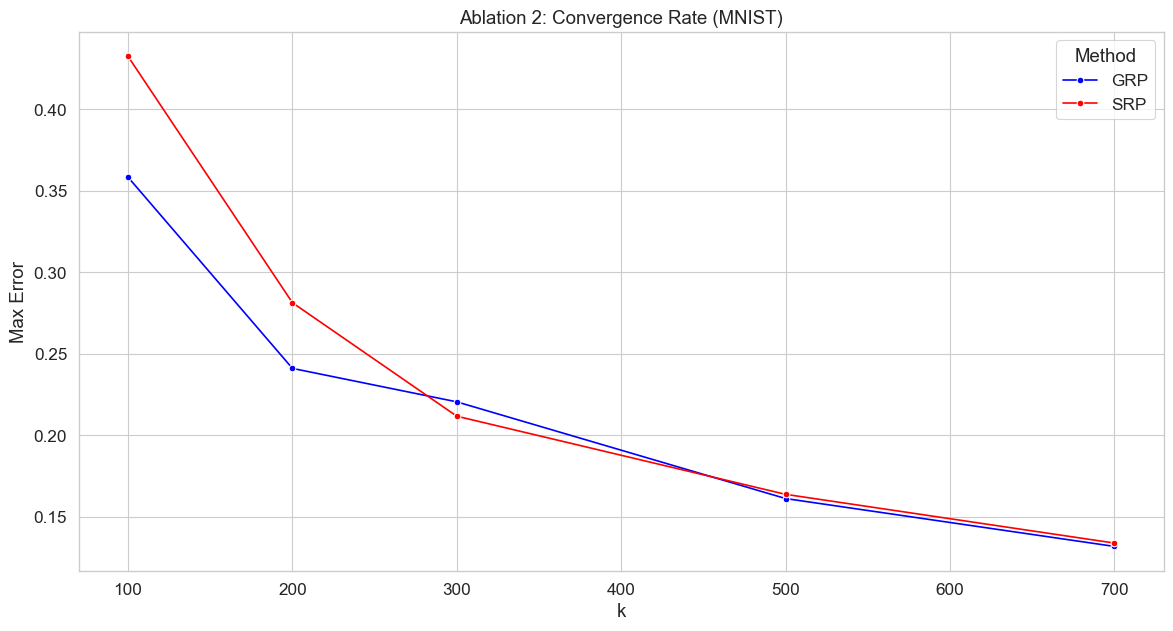

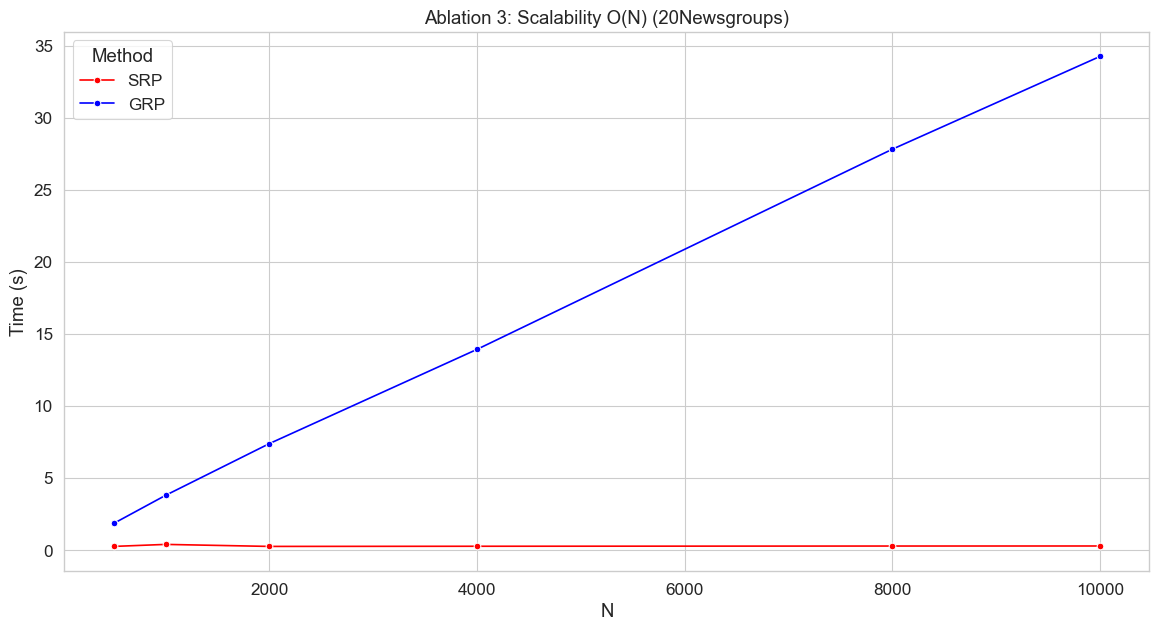

In [3]:
import os
import sys
import time
import tarfile
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection, johnson_lindenstrauss_min_dim
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files
from sklearn.utils import shuffle

# Tắt warning chiều dữ liệu để output sạch
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['figure.figsize'] = (20, 10)
np.random.seed(42)

# ==========================================
# 1. UTILS & THEORY
# ==========================================
def h_bennett(u):
    if u <= -1: return float('inf')
    return (1 + u) * np.log(1 + u) - u

def calculate_m_bennett(n, epsilon, delta, density):
    u = epsilon / density
    bennett_val = h_bennett(u)
    if bennett_val < 1e-12: return johnson_lindenstrauss_min_dim(n, eps=epsilon)
    m = np.log(2/delta) / ((epsilon**2 / 2) * bennett_val)
    return int(np.ceil(m))

def estimate_ram(n_components, n_features, density, method="GRP"):
    if method == "GRP": return (n_components * n_features * 8) / (1024**2)
    else: 
        nnz = int(n_components * n_features * density)
        return (nnz * 12 + (n_components + 1) * 4) / (1024**2)

# ==========================================
# 2. ROBUST LOADERS (IMPLEMENTATION SETUP 5.1)
# ==========================================
def safe_extract_tar(filepath, extract_path):
    if os.path.exists(extract_path): shutil.rmtree(extract_path)
    with tarfile.open(filepath, "r:gz") as tar:
        if sys.version_info >= (3, 12): tar.extractall(path=extract_path, filter='data')
        else: tar.extractall(path=extract_path)

def load_mnist(filepath='mnist_in_csv.gz'):
    """
    5.1.1 Image Normalization: Min-Max scaling to [0, 1]
    """
    print(f"\n[Loader] Loading MNIST...")
    try:
        df = pd.read_csv(filepath, compression='gzip')
        # Normalize features: x_norm = x_raw / 255.0
        X = df.iloc[:, 1:].values.astype(np.float32) / 255.0
        X = shuffle(X, random_state=42)
        return X, "MNIST"
    except Exception as e: 
        print(f"Err MNIST: {e}")
        return None, None

def load_20news(filepath='20news-bydate.tar.gz'):
    """
    5.1.2 Text Vectorization: TF-IDF, min_df=2, no hard cap
    """
    print(f"\n[Loader] Loading 20News...")
    extract_path = "./temp_20news_ul"
    try:
        safe_extract_tar(filepath, extract_path)
        subdirs = [os.path.join(extract_path, d) for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
        target_dir = next((d for d in subdirs if 'train' in d), subdirs[0])
        data = load_files(target_dir, encoding='latin1')
        
        # Exact setup: min_df=2, no max_features constraint
        vectorizer = TfidfVectorizer(min_df=2, stop_words='english')
        X = vectorizer.fit_transform(data.data)
        return X, "20Newsgroups"
    except Exception as e: 
        print(f"Err 20News: {e}")
        return None, None

def load_ecommerce(filepath='ecommerce.gz'):
    """
    5.1.2 Text Vectorization: TF-IDF, max_features=10,000, drop missing
    """
    print(f"\n[Loader] Loading Ecommerce...")
    try:
        df = pd.read_csv(filepath, compression='gzip', encoding='ISO-8859-1')
        
        # Drop rows with missing descriptions
        df = df.dropna(subset=['Description'])
        
        # Exact setup: max_features=10,000
        vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
        X = vectorizer.fit_transform(df['Description'].astype(str))
        
        return X, "Ecommerce"
    except Exception as e: 
        print(f"Err Ecommerce: {e}")
        return None, None

# ==========================================
# 3. EXPERIMENT ENGINES (IMPLEMENTATION SETUP 5.2 & 5.4)
# ==========================================
def collect_errors(X_orig, X_proj):
    # 5.2 Sparse Handling: Convert to dense ONLY before calculation
    if sparse.issparse(X_orig): X_orig = X_orig.toarray()
    
    d_orig = euclidean_distances(X_orig); d_proj = euclidean_distances(X_proj)
    idx = np.triu_indices(d_orig.shape[0], k=1)
    dist_o = d_orig[idx]; dist_p = d_proj[idx]
    
    valid = dist_o > 1e-6
    if np.sum(valid) == 0: return np.array([])
    return np.abs(dist_p[valid] / dist_o[valid] - 1.0)

def run_evaluation_suite(datasets):
    print("\n" + "="*50 + "\nPHASE 1: EVALUATION (Dynamic k)\n" + "="*50)
    stats = []; scatter_data = {}
    eps = 0.1
    
    # 5.2 Sampling Strategy: Limit N = 5,000
    SAMPLE_SIZE = 5000
    
    for X, name in datasets:
        n, d = X.shape
        k_jl = johnson_lindenstrauss_min_dim(n, eps=eps)
        k = min(k_jl, d)
        
        print(f">>> Processing {name} (N={n}, d={d}) -> Calculated k={k}")
        
        # Sampling
        actual_sample = min(SAMPLE_SIZE, n)
        idx = np.random.choice(n, actual_sample, replace=False)
        X_sample = X[idx]

        # 1. GRP
        t0 = time.time()
        grp = GaussianRandomProjection(n_components=k, random_state=42)
        if d > 5000: 
            grp.fit(X[:200].toarray()) # Sim fitting time
            t_grp = (time.time() - t0) * (n/200)
            X_grp = grp.transform(X_sample.toarray() if sparse.issparse(X_sample) else X_sample)
        else:
            grp.fit(X); t_grp = time.time() - t0
            X_grp = grp.transform(X_sample.toarray() if sparse.issparse(X_sample) else X_sample)
            
        err_grp = collect_errors(X_sample, X_grp)
        mem_grp = estimate_ram(k, d, 1.0, "GRP")

        # 2. SRP
        t0 = time.time()
        srp = SparseRandomProjection(n_components=k, density='auto', random_state=42)
        srp.fit(X); t_srp = time.time() - t0
        X_srp = srp.transform(X_sample)
        err_srp = collect_errors(X_sample, X_srp)
        
        actual_density = 1 / np.sqrt(d)
        
        stats.append({"Dataset": name, "Method": "GRP", "Time": t_grp, "Memory": mem_grp, "Mean Error": np.mean(err_grp), "Max Error": np.max(err_grp)})
        stats.append({"Dataset": name, "Method": "SRP", "Time": t_srp, "Memory": estimate_ram(k, d, actual_density, "SRP"), "Mean Error": np.mean(err_srp), "Max Error": np.max(err_srp)})
        scatter_data[name] = {"GRP": err_grp, "SRP": err_srp, "k": k, "d": d, "N": n}

    return pd.DataFrame(stats), scatter_data

def run_ablation_suite(datasets):
    print("\n" + "="*50 + "\nPHASE 2: FULL ABLATION (Density, Convergence, Scalability)\n" + "="*50)
    eps = 0.1; delta = 0.05
    # Use consistent sampling size for Ablation
    ABLATION_SAMPLE = 2000 
    
    # 1. Density (Ecommerce)
    print(">>> ABLATION 1: Density vs Theory (Ecommerce)")
    abl_dens = []
    try:
        X_ecom = [d[0] for d in datasets if d[1]=="Ecommerce"][0]
        n, d = X_ecom.shape
        X_sample = X_ecom[:ABLATION_SAMPLE]
        k_fixed = min(johnson_lindenstrauss_min_dim(n, eps=eps), d)
        densities = [0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
        for p in densities:
            m_theory = calculate_m_bennett(n, eps, delta, p)
            srp = SparseRandomProjection(n_components=k_fixed, density=p, random_state=42)
            srp.fit(X_sample)
            errs = collect_errors(X_sample, srp.transform(X_sample))
            abl_dens.append({"Density": p, "Theory_m": m_theory, "Max Error": np.max(errs)})
    except: print("Skipping Ablation 1")

    # 2. Convergence k (MNIST) - Implements 5.4 Projection Loop
    print(">>> ABLATION 2: Convergence of k (MNIST)")
    abl_conv = []
    try:
        X_mnist = [d[0] for d in datasets if d[1]=="MNIST"][0]
        d_mnist = X_mnist.shape[1]
        k_range = [k for k in [100, 200, 300, 500, 700] if k < d_mnist]
        X_sample_m = X_mnist[:ABLATION_SAMPLE]
        for k in k_range:
            grp = GaussianRandomProjection(n_components=k, random_state=42)
            grp.fit(X_sample_m)
            abl_conv.append({"k": k, "Method": "GRP", "Max Error": np.max(collect_errors(X_sample_m, grp.transform(X_sample_m)))})
            srp = SparseRandomProjection(n_components=k, density='auto', random_state=42)
            srp.fit(X_sample_m)
            abl_conv.append({"k": k, "Method": "SRP", "Max Error": np.max(collect_errors(X_sample_m, srp.transform(X_sample_m)))})
    except: print("Skipping Ablation 2")

    # 3. Scalability N (20Newsgroups)
    print(">>> ABLATION 3: Scalability (20Newsgroups)")
    abl_scale = []
    try:
        X_news = [d[0] for d in datasets if d[1]=="20Newsgroups"][0]
        max_n = X_news.shape[0]
        n_range = [n for n in [500, 1000, 2000, 4000, 8000, 10000] if n <= max_n]
        k_s = 396 # Fix k
        
        for n_sub in n_range:
            X_sub = X_news[:n_sub]
            # SRP Time
            t0 = time.time()
            srp = SparseRandomProjection(n_components=k_s, density='auto')
            srp.fit(X_sub); srp.transform(X_sub)
            t_srp = time.time() - t0
            
            # GRP Time (Est for large N)
            t0 = time.time()
            grp = GaussianRandomProjection(n_components=k_s)
            grp.fit(X_sub[:min(200, n_sub)].toarray()) 
            t_grp = (time.time() - t0) * (n_sub / 200)
            
            abl_scale.append({"N": n_sub, "Method": "SRP", "Time": t_srp})
            abl_scale.append({"N": n_sub, "Method": "GRP", "Time": t_grp})
    except: print("Skipping Ablation 3")

    return pd.DataFrame(abl_dens), pd.DataFrame(abl_conv), pd.DataFrame(abl_scale)

# ==========================================
# 4. VISUALIZATION
# ==========================================
def plot_full_report(df_res, scatter_data, df_dens, df_conv, df_scale):
    # 1. SCATTER PLOTS (Evaluation)
    for name, data in scatter_data.items():
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
        viz_sample = min(2000, len(data["GRP"]))
        idx_g = np.random.choice(len(data["GRP"]), viz_sample, replace=False)
        idx_s = np.random.choice(len(data["SRP"]), viz_sample, replace=False)
        
        # GRP
        axes[0].scatter(np.arange(len(idx_g)), data["GRP"][idx_g], c='blue', alpha=0.4, s=15)
        axes[0].set_title(f"GRP on {name}", fontweight='bold', color='darkblue')
        axes[0].axhline(0.1, c='green', ls='--', label='Target ε=0.1')
        
        # SRP
        axes[1].scatter(np.arange(len(idx_s)), data["SRP"][idx_s], c='red', alpha=0.4, s=15)
        axes[1].set_title(f"SRP on {name}", fontweight='bold', color='darkred')
        axes[1].axhline(0.1, c='green', ls='--', label='Target ε=0.1')
        
        info = f"Dataset: {name}\nN={data['N']}, d={data['d']}\nCalculated k={data['k']}"
        fig.text(0.5, 0.92, info, ha='center', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="gray"))
        plt.tight_layout(rect=[0, 0, 1, 0.88]); plt.show()

    # 2. RESOURCES & ERRORS
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    sns.barplot(data=df_res, x="Dataset", y="Time", hue="Method", ax=axes[0,0], palette=["blue", "red"])
    axes[0,0].set_yscale('log'); axes[0,0].set_title("Time Efficiency (Log Scale)")
    
    sns.barplot(data=df_res, x="Dataset", y="Memory", hue="Method", ax=axes[0,1], palette=["blue", "red"])
    axes[0,1].set_yscale('log'); axes[0,1].set_title("Memory Footprint (Log Scale)")
    
    sns.barplot(data=df_res, x="Dataset", y="Mean Error", hue="Method", ax=axes[1,0], palette=["blue", "red"])
    axes[1,0].set_title("Mean Error (Expectation)"); axes[1,0].axhline(0.1, c='k', ls='--')
    
    sns.barplot(data=df_res, x="Dataset", y="Max Error", hue="Method", ax=axes[1,1], palette=["blue", "red"])
    axes[1,1].set_title("Max Error (Worst Case)"); axes[1,1].axhline(0.1, c='k', ls='--')
    plt.tight_layout(); plt.show()

    # 3. ABLATION PLOTS
    if not df_dens.empty:
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax1.set_xscale('log'); ax1.set_xlabel('Density (p)')
        ax1.set_ylabel('Theoretical m (Bennett)', color='green')
        ax1.plot(df_dens['Density'], df_dens['Theory_m'], 'g--o', label='Bennett Theory')
        ax2 = ax1.twinx(); ax2.set_ylabel('Empirical Max Error', color='red')
        ax2.plot(df_dens['Density'], df_dens['Max Error'], 'r-x', label='Max Error')
        plt.title("Ablation 1: Density vs Theory (Ecommerce)"); plt.show()
    
    if not df_conv.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_conv, x="k", y="Max Error", hue="Method", marker='o', palette=["blue", "red"])
        plt.title("Ablation 2: Convergence Rate (MNIST)"); plt.ylabel("Max Error"); plt.show()
    
    if not df_scale.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_scale, x="N", y="Time", hue="Method", marker='o', palette=["red", "blue"])
        plt.title("Ablation 3: Scalability O(N) (20Newsgroups)"); plt.ylabel("Time (s)"); plt.show()

if __name__ == "__main__":
    ds = []
    x1,n1 = load_mnist(); 
    if x1 is not None: ds.append((x1,n1))
    x2,n2 = load_20news(); 
    if x2 is not None: ds.append((x2,n2))
    x3,n3 = load_ecommerce(); 
    if x3 is not None: ds.append((x3,n3))
    
    if ds:
        df_res, scatter_data = run_evaluation_suite(ds)
        df_dens, df_conv, df_scale = run_ablation_suite(ds)
        plot_full_report(df_res, scatter_data, df_dens, df_conv, df_scale)

# Setup dataset

In [2]:
def get_dataset(size_type):
    """
    Hàm tải dữ liệu. Sử dụng OpenML để tránh lỗi HTTP 403 và đảm bảo dữ liệu thuần số.
    """
    if size_type == 'small':
        print("\n[Data] Đang tải Digits (Small: D <= 100)...")
        # Dữ liệu tích hợp sẵn, không cần mạng
        data = load_digits()
        X = data.data
        y = data.target
        
    elif size_type == 'medium':
        print("\n[Data] Đang tải MNIST (Medium: 100 < D < 10000)...")
        # MNIST Original từ OpenML (D=784)
        # as_frame=False để trả về numpy array ngay lập tức
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
        
        # Ép kiểu sang float để tránh lỗi type object
        X = X.astype(np.float32)
        X = X / 255.0
        
        # Lấy mẫu 2000 dòng để chạy nhanh
        X, y = resample(X, y, n_samples=2000, random_state=42)
        
    elif size_type == 'large':
        print("\n[Data] Đang tải Arcene (Large: D >= 10000)...")
        # Sử dụng bộ dữ liệu ARCENE (ID 1458)
        # Đây là bộ dữ liệu chuẩn NIPS 2003: N=200 (khi gộp train/valid), D=10,000
        # Dữ liệu này sạch và chắc chắn là số.
        try:
            X, y = fetch_openml(data_id=1458, return_X_y=True, as_frame=False, parser='auto')
        except Exception:
            print("Fallback sang bộ Dexter (ID 4135)...")
            # Fallback: Dexter (D=20,000)
            X, y = fetch_openml(data_id=4135, return_X_y=True, as_frame=False, parser='auto')

        # QUAN TRỌNG: Ép kiểu dữ liệu về float để đảm bảo không còn chuỗi (str)
        # np.nan_to_num sẽ thay thế các giá trị NaN (nếu có) bằng 0
        try:
            if hasattr(X, "toarray"): # Nếu là sparse matrix
                X = X.toarray()
            X = X.astype(np.float32)
            X = np.nan_to_num(X)
        except ValueError as e:
            print(f"Cảnh báo dữ liệu: {e}. Đang cố gắng sửa...")
            # Nếu vẫn lỗi, thử clean lần cuối
            X = np.nan_to_num(pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').fillna(0).values)

        # Dataset này số dòng (N) ít nên không cần resample, chạy full luôn
        # Chuẩn hóa dữ liệu
        max_val = np.abs(X).max()
        if max_val > 0:
            X = X / max_val

    print(f" -> Kích thước dữ liệu: {X.shape} (N={X.shape[0]}, D={X.shape[1]})")
    return X, y

# Metrics

In [3]:
def compute_reconstruction_error(X_orig, X_proj):
    """
    Tính lỗi sai biệt khoảng cách (Distortion).
    Theo paper: kiểm tra xem khoảng cách đôi một có được bảo toàn không.
    """
    # Để tiết kiệm RAM và CPU, chỉ tính trên 500 mẫu ngẫu nhiên
    n_samples = min(X_orig.shape[0], 500)
    indices = np.random.choice(X_orig.shape[0], n_samples, replace=False)
    
    # Lấy dữ liệu mẫu (hỗ trợ cả Sparse Matrix cho RCV1)
    X_sample_orig = X_orig[indices]
    X_sample_proj = X_proj[indices]
    
    # Tính khoảng cách
    d_orig = euclidean_distances(X_sample_orig)
    d_proj = euclidean_distances(X_sample_proj)
    
    # Mask để tránh chia cho 0 (đường chéo chính)
    mask = d_orig > 1e-6
    
    # Tính tỷ lệ lỗi: |d_proj / d_orig - 1|
    # Paper Equation (9): (1-eps) ||u-v||^2 <= ||Pv - Pu||^2 <= (1+eps) ||u-v||^2
    distortion = np.abs((d_proj[mask] / d_orig[mask]) - 1)
    
    return np.mean(distortion)

# BENCHMARK ENGINE

In [4]:
def run_benchmark(X, dataset_name):
    n_samples, n_features = X.shape
    
    # Các mức n_components (k) để test
    # Chọn k nhỏ hơn D gốc
    k_list = [10, 50, 100, 200, 500]
    k_list = [k for k in k_list if k < n_features]
    
    # Định nghĩa 3 phương pháp theo Paper
    # 1. Gaussian (Baseline) [cite: 13]
    # 2. Sparse (Achlioptas): density = 1/3 (s=3) 
    # 3. Very Sparse (Ping Li): density = 1/sqrt(D) (s=sqrt(D)) 
    
    density_very_sparse = 1 / np.sqrt(n_features)
    
    methods = {
        "Gaussian RP": (GaussianRandomProjection, {}),
        "Sparse RP (s=3)": (SparseRandomProjection, {'density': 1/3}),
        f"Very Sparse (s=√{n_features})": (SparseRandomProjection, {'density': density_very_sparse})
    }
    
    results = []

    print(f"Bắt đầu Benchmark bộ: {dataset_name}...")
    
    for k in k_list:
        for method_name, (ModelClass, params) in methods.items():
            # Khởi tạo model
            transformer = ModelClass(n_components=k, random_state=42, **params)
            
            # Đo thời gian Fit + Transform
            start_time = time.time()
            X_new = transformer.fit_transform(X)
            run_time = time.time() - start_time
            
            # Đo lỗi tái tạo
            error = compute_reconstruction_error(X, X_new)
            
            # Lưu kết quả
            results.append({
                "Dataset": dataset_name,
                "Components (k)": k,
                "Method": method_name,
                "Time (s)": run_time,
                "Reconstruction Error": error,
                "Density Used": params.get('density', 1.0)
            })
            
    return pd.DataFrame(results)

# VISUALIZATION

In [5]:
def plot_benchmark(df, dataset_name, ax_time, ax_error):
    data = df[df["Dataset"] == dataset_name]
    methods = data["Method"].unique()
    
    for method in methods:
        subset = data[data["Method"] == method]
        # Vẽ thời gian
        ax_time.plot(subset["Components (k)"], subset["Time (s)"], marker='o', label=method)
        # Vẽ lỗi
        ax_error.plot(subset["Components (k)"], subset["Reconstruction Error"], marker='s', label=method)
    
    ax_time.set_title(f"Processing Time - {dataset_name}")
    ax_time.set_xlabel("k")
    ax_time.set_ylabel("Seconds")
    ax_time.legend()
    ax_time.grid(True)
    
    ax_error.set_title(f"Reconstruction Error - {dataset_name}")
    ax_error.set_xlabel("k")
    ax_error.set_ylabel("Mean Relative Error")
    ax_error.legend()
    ax_error.grid(True)

# Main


[Data] Đang tải Digits (Small: D <= 100)...
 -> Kích thước dữ liệu: (1797, 64) (N=1797, D=64)
Bắt đầu Benchmark bộ: SMALL (D=64)...

[Data] Đang tải MNIST (Medium: 100 < D < 10000)...
 -> Kích thước dữ liệu: (2000, 784) (N=2000, D=784)
Bắt đầu Benchmark bộ: MEDIUM (D=784)...

[Data] Đang tải Arcene (Large: D >= 10000)...
 -> Kích thước dữ liệu: (200, 10000) (N=200, D=10000)
Bắt đầu Benchmark bộ: LARGE (D=10000)...

[Result] Đang vẽ biểu đồ so sánh...


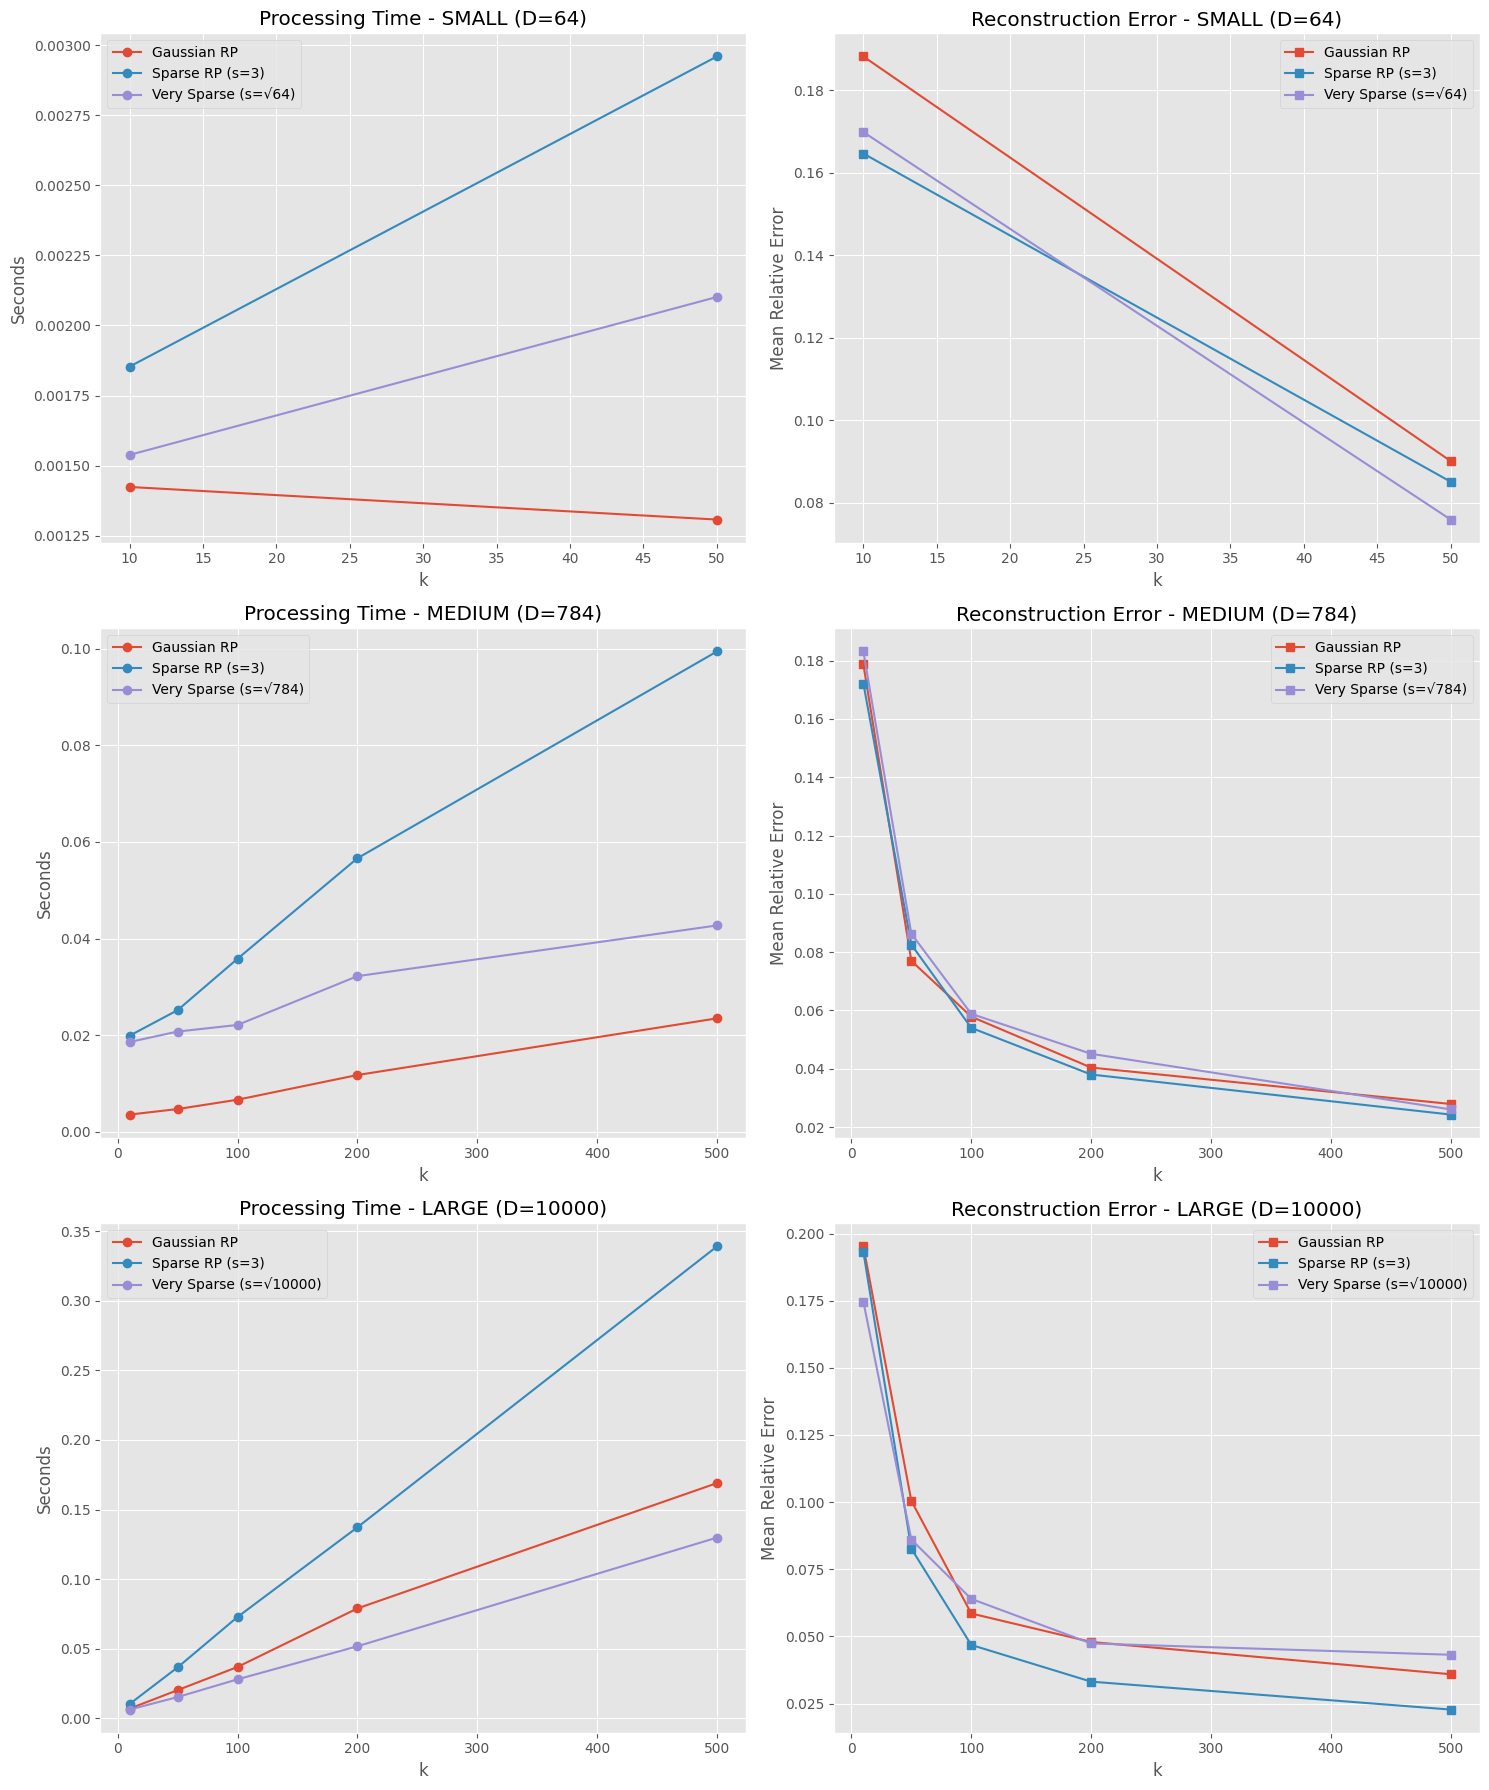


--- Bảng kết quả chi tiết (Top 10 dòng) ---
          Dataset  Components (k)                Method  Time (s)  \
0    SMALL (D=64)              10           Gaussian RP  0.001424   
1    SMALL (D=64)              10       Sparse RP (s=3)  0.001853   
2    SMALL (D=64)              10   Very Sparse (s=√64)  0.001538   
3    SMALL (D=64)              50           Gaussian RP  0.001307   
4    SMALL (D=64)              50       Sparse RP (s=3)  0.002960   
5    SMALL (D=64)              50   Very Sparse (s=√64)  0.002102   
0  MEDIUM (D=784)              10           Gaussian RP  0.003549   
1  MEDIUM (D=784)              10       Sparse RP (s=3)  0.019883   
2  MEDIUM (D=784)              10  Very Sparse (s=√784)  0.018576   
3  MEDIUM (D=784)              50           Gaussian RP  0.004689   

   Reconstruction Error  Density Used  
0              0.188168      1.000000  
1              0.164641      0.333333  
2              0.169845      0.125000  
3              0.090111      1.0000

In [6]:
if __name__ == "__main__":
    # 1. Chọn Dataset
    datasets_to_run = ['small', 'medium', 'large'] 
    all_results = pd.DataFrame()

    # 2. Chạy vòng lặp
    for size in datasets_to_run:
        X, y = get_dataset(size)
        name = f"{size.upper()} (D={X.shape[1]})"
        df_res = run_benchmark(X, name)
        all_results = pd.concat([all_results, df_res])

    # 3. Vẽ biểu đồ tổng hợp
    print("\n[Result] Đang vẽ biểu đồ so sánh...")
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    unique_datasets = all_results["Dataset"].unique()
    for i, ds_name in enumerate(unique_datasets):
        plot_benchmark(all_results, ds_name, axes[i][0], axes[i][1])
        
    plt.tight_layout()
    plt.show()
    
    # 4. In bảng kết quả mẫu
    print("\n--- Bảng kết quả chi tiết (Top 10 dòng) ---")
    print(all_results.head(10))